In [110]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import math
import time
from module.lib.layers import *
import module.lib.functions as func
from module.lib import optical_chart
import pandas as pd
import cv2
import glob
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.size"]=18

In [27]:
def propagation(pahse, wavelength, z):
    rcp_x = np.ones_like(phase) * np.exp(-1.0j*phase)
    lcp_x = np.ones_like(phase) * np.exp(1.0j*phase)
    rcp_x = func.angular_spectrum(rcp_x, wavelength, z, 1.0e-6, 1.0)
    lcp_x = func.angular_spectrum(lcp_x, wavelength, z, 1.0e-6, 1.0)
    rcp_y = 1.0j * rcp_x
    lcp_y = -1.0j * lcp_x

    E0 = rcp_x + lcp_x
    I0 = tf.abs(E0) ** 2 / 2.0
    E90 = rcp_y + lcp_y
    I90 = tf.abs(E90) ** 2 / 2.0
    E45_x = (rcp_x + rcp_y + lcp_x + lcp_y) / 2.0
    E45_y = (rcp_x + rcp_y + lcp_x + lcp_y) / 2.0
    I45 = tf.abs(E45_x) ** 2 / 2 + tf.abs(E45_y) ** 2 / 2.0
    E135_x = (rcp_x - rcp_y + lcp_x - lcp_y) / 2.0
    E135_y = (-rcp_x + rcp_y - lcp_x + lcp_y) / 2.0
    I135 = tf.abs(E135_x) ** 2 / 2 + tf.abs(E135_y) ** 2 / 2.0

    S1 = I0 - I90
    S2 = I45 - I135

    # theta = tf.where(S1**2 > self.eps, tf.atan(S2*S1 / S1**2) / 2.0, tf.atan(S2*S1 / self.eps) / 2.0,)
    eps = 1.0e-24
    return np.arctan(S2 * S1 / (S1 ** 2 + eps)) / 2.0

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3553/4194288848.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


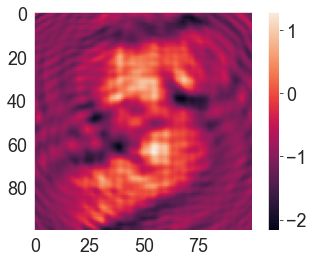

In [29]:
wavelength = 532e-9
z = 0.5e-3
phase = ((np.loadtxt("data/phase/100px/train_5.csv")) * 2.0 -1.0) * 1. * np.pi / 180

theta = propagation(phase, wavelength, z)
plt.imshow(theta * 180 / np.pi)
plt.grid(False)
plt.colorbar()

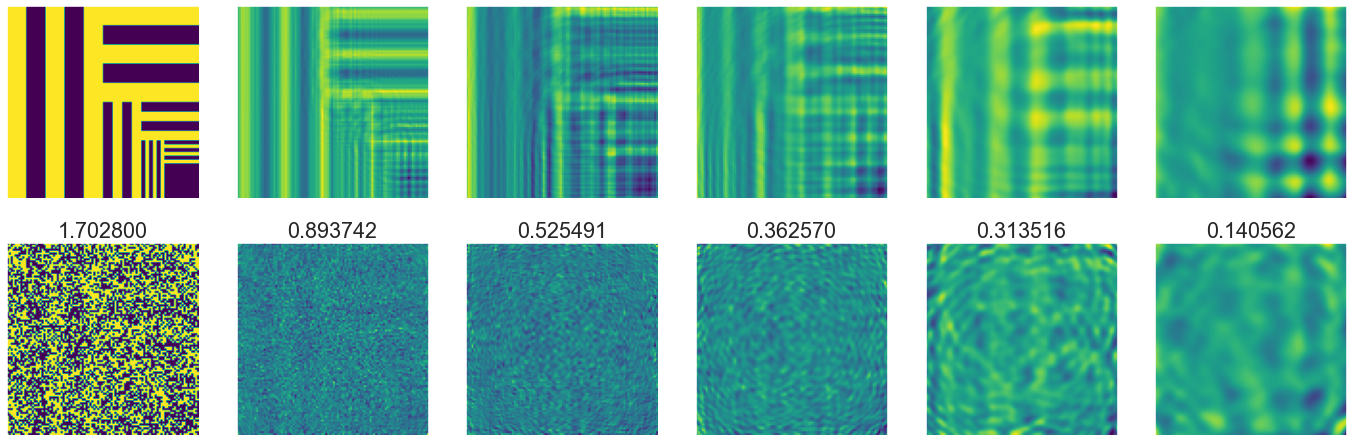

In [111]:
z_list = [0.0, 0.1e-3, 0.3e-3, 0.5e-3, 1.0e-3, 2.0e-3]

fig, axes = plt.subplots(2, len(z_list), figsize=(4*len(z_list), 4*2))

#binary = np.loadtxt("data/phase/100px/train_5.csv") * 2 - 1
binary = optical_chart.char1((100, 100)) * 2 -1
phase = binary * 1. * np.pi / 180

iter = 200

ini_img = []

for i, z in enumerate(z_list):
    axes[0,i].cla()
    theta = propagation(phase, wavelength, z) * 180/np.pi
    ini_img.append(theta)
    axes[0,i].imshow(theta, cmap="viridis")
    axes[0,i].grid(False)
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

def update(frame):
    global phase
    global binary
    rand = np.random.uniform(0, 1, phase.shape)
    binary = binary * np.where(rand >= 0.995, -1, 1)
    phase = binary * 1. * np.pi / 180
    for i, z in enumerate(z_list):
        axes[1,i].cla()
        theta = propagation(phase, wavelength, z) * 180/np.pi
        mse = np.mean((ini_img[i] - theta)**2)
        axes[1,i].imshow(theta, cmap="viridis")
        axes[1,i].set_title("{:f}".format(mse))
        axes[1,i].grid(False)
        axes[1,i].set_xticks([])
        axes[1,i].set_yticks([])



ani = animation.FuncAnimation(fig, update, frames=iter, interval=1, blit=False,
                                repeat_delay=1000)
ani.save('gif/robust.gif', writer='pillow')

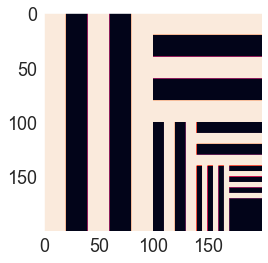

In [109]:
size = (200, 200)
chart = np.zeros(size)
w1 = int(size[1]/10)
chart[:, 0:w1] = 1
chart[:, w1*2:w1*3] = 1
chart[:, w1*4:w1*5] = 1

w2 = int(size[0]/10)
chart[0: w2, w1*5:] = 1
chart[w2*2: w2*3, w1*5:] = 1
chart[w2*4: w2*5, w1*5:] = 1

w3 = int(size[1]/20)
chart[w2*5:, w1*5+w3*1:w1*5+w3*2] = 1
chart[w2*5:, w1*5+w3*3:w1*5+w3*4] = 1

w4 = int(size[0]/20)
chart[w2*5 + w4: w2*5 + w4*2, w1*5 + w3*4:] = 1
chart[w2*5 + w4*3: w2*5 + w4*4, w1*5 + w3*4:] = 1

w5 = int(size[1]/40)
chart[w2*5 + w4*4:, w1*5 + w3*4 + w5 : w1*5 + w3*4 + w5*2] = 1
chart[w2*5 + w4*4:, w1*5 + w3*4 + w5 * 3 : w1*5 + w3*4 + w5*4] = 1
chart[w2*5 + w4*4:, w1*5 + w3*4 + w5 * 5 : w1*5 + w3*4 + w5*6] = 1

w6 = int(size[0]/40)
chart[w2*5 + w4*4 + w6: w2*5 + w4*4 + w6*2, w1*5 + w3*4 + w5*6:] = 1
chart[w2*5 + w4*4 + w6*3: w2*5 + w4*4 + w6*4, w1*5 + w3*4 + w5*6:] = 1
chart[w2*5 + w4*4 + w6*5: w2*5 + w4*4 + w6*6, w1*5 + w3*4 + w5*6:] = 1

plt.imshow(chart)
plt.grid(False)

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3553/1745753671.py:14: RuntimeWarning: invalid value encountered in sqrt
  w = np.where((UU**2 + VV**2) <= 1 / wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3553/1745753671.py:20: RuntimeWarning: overflow encountered in exp
  x2 = x1 * np.exp(1.0j * phi)
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3553/1745753671.py:20: RuntimeWarning: invalid value encountered in multiply
  x2 = x1 * np.exp(1.0j * phi)
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3553/1745753671.py:37: RuntimeWarning: invalid value encountered in sqrt
  w = np.where((UU**2 + VV**2) <= 1 / wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3553/1745753671.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor

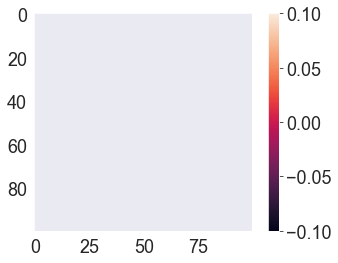

In [477]:
shape = (100, 100)

wavelength = 800e-9
d = 0.5e-6
z = 0.1e-3

phi = np.random.random(shape)
data = np.loadtxt("data/phase/100px/train_5.csv")
y = np.zeros(shape)
y[45:55,45:55] = 1
u = np.fft.fftfreq(shape[1], d)
v = np.fft.fftfreq(shape[0], d)
UU, VV = np.meshgrid(u, v)
w = np.where((UU**2 + VV**2) <= 1 / wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
H = np.exp(1.0j * 2.0 * np.pi * w * z)
eta = 0.01
iter = 100
for i in range(iter):
    x1 = data
    x2 = x1 * np.exp(1.0j * phi)
    fft_x2 = np.fft.fft2(x2)
    x3 = np.fft.ifft2(fft_x2 * H)
    x4 = x3 * x3.conjugate()
    dLdphi = 2 * (x4 - y)
    dLdphi = dLdphi * x3.conjugate()
    dLdphi = dLdphi * H
    dLdphi = dLdphi * 1.0j * x2
    phi = phi - eta * dLdphi


x1 = data
x2 = x1 * np.exp(1.0j * phi)
fft_x2 = np.fft.fft2(x2)
u = np.fft.fftfreq(shape[1], d)
v = np.fft.fftfreq(shape[0], d)
UU, VV = np.meshgrid(u, v)
w = np.where((UU**2 + VV**2) <= 1 / wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
H = np.exp(1.0j * 2.0 * np.pi * w * z)
x3 = np.fft.ifft2(fft_x2 * H)
x4 = x3 * x3.conjugate()
plt.imshow(np.abs(x4))
plt.grid(False)
plt.colorbar()

In [473]:
w

array([[1250000.        , 1249839.98975869, 1249359.83607606, ...,
        1248559.16960311, 1249359.83607606, 1249839.98975869],
       [1249839.98975869, 1249679.95902951, 1249199.74383603, ...,
        1248398.97468718, 1249199.74383603, 1249679.95902951],
       [1249359.83607606, 1249199.74383603, 1248719.34396805, ...,
        1247918.26655434, 1248719.34396805, 1249199.74383603],
       ...,
       [1248559.16960311, 1248398.97468718, 1247918.26655434, ...,
        1247116.67457379, 1247918.26655434, 1248398.97468718],
       [1249359.83607606, 1249199.74383603, 1248719.34396805, ...,
        1247918.26655434, 1248719.34396805, 1249199.74383603],
       [1249839.98975869, 1249679.95902951, 1249199.74383603, ...,
        1248398.97468718, 1249199.74383603, 1249679.95902951]])

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_3553/1205942152.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


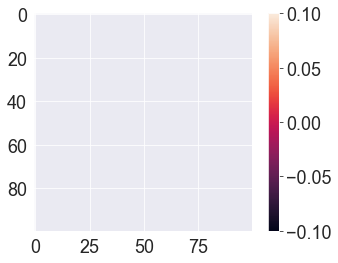

In [459]:
plt.imshow(phi.real)
plt.colorbar()